# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [5]:
datadir = 'Simulated_Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

C:\Users\Urvesh Parmar\AppData\Local\Temp\ipykernel_21904\974551716.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,U:\Clubs\SAE\Simulated_data\IMG\center_2023_03_26_18_30_33_891.jpg,U:\Clubs\SAE\Simulated_data\IMG\left_2023_03_26_18_30_33_891.jpg,U:\Clubs\SAE\Simulated_data\IMG\right_2023_03_26_18_30_33_891.jpg,0.0,0.0,0.0,0.000024
1,U:\Clubs\SAE\Simulated_data\IMG\center_2023_03_26_18_30_33_960.jpg,U:\Clubs\SAE\Simulated_data\IMG\left_2023_03_26_18_30_33_960.jpg,U:\Clubs\SAE\Simulated_data\IMG\right_2023_03_26_18_30_33_960.jpg,0.0,0.0,0.0,0.000024
2,U:\Clubs\SAE\Simulated_data\IMG\center_2023_03_26_18_30_34_030.jpg,U:\Clubs\SAE\Simulated_data\IMG\left_2023_03_26_18_30_34_030.jpg,U:\Clubs\SAE\Simulated_data\IMG\right_2023_03_26_18_30_34_030.jpg,0.0,0.0,0.0,0.000022
3,U:\Clubs\SAE\Simulated_data\IMG\center_2023_03_26_18_30_34_100.jpg,U:\Clubs\SAE\Simulated_data\IMG\left_2023_03_26_18_30_34_100.jpg,U:\Clubs\SAE\Simulated_data\IMG\right_2023_03_26_18_30_34_100.jpg,0.0,0.0,0.0,0.000022
4,U:\Clubs\SAE\Simulated_data\IMG\center_2023_03_26_18_30_34_173.jpg,U:\Clubs\SAE\Simulated_data\IMG\left_2023_03_26_18_30_34_173.jpg,U:\Clubs\SAE\Simulated_data\IMG\right_2023_03_26_18_30_34_173.jpg,0.0,0.0,0.0,0.000022


# Data Exploration

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_03_26_18_30_33_891.jpg,left_2023_03_26_18_30_33_891.jpg,right_2023_03_26_18_30_33_891.jpg,0.0,0.0,0.0,0.000024
1,center_2023_03_26_18_30_33_960.jpg,left_2023_03_26_18_30_33_960.jpg,right_2023_03_26_18_30_33_960.jpg,0.0,0.0,0.0,0.000024
2,center_2023_03_26_18_30_34_030.jpg,left_2023_03_26_18_30_34_030.jpg,right_2023_03_26_18_30_34_030.jpg,0.0,0.0,0.0,0.000022
3,center_2023_03_26_18_30_34_100.jpg,left_2023_03_26_18_30_34_100.jpg,right_2023_03_26_18_30_34_100.jpg,0.0,0.0,0.0,0.000022
4,center_2023_03_26_18_30_34_173.jpg,left_2023_03_26_18_30_34_173.jpg,right_2023_03_26_18_30_34_173.jpg,0.0,0.0,0.0,0.000022


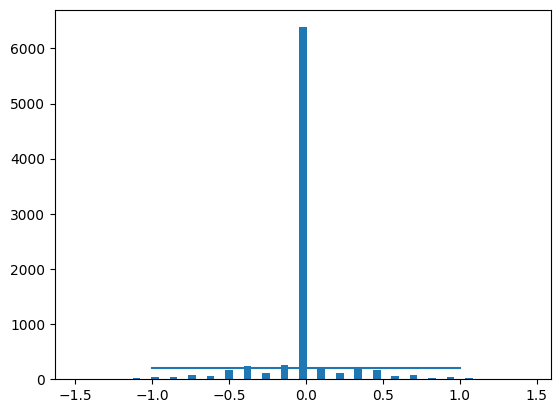

In [7]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

Training Samples: 6713
Valid Samples: 1679


Text(0.5, 1.0, 'Validation set')

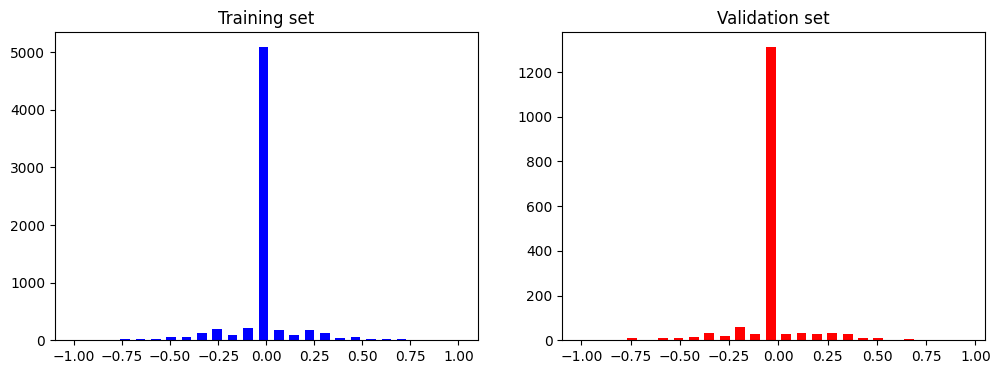

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

# Data Pre-Processing

In [10]:
def img_preprocess(img):
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

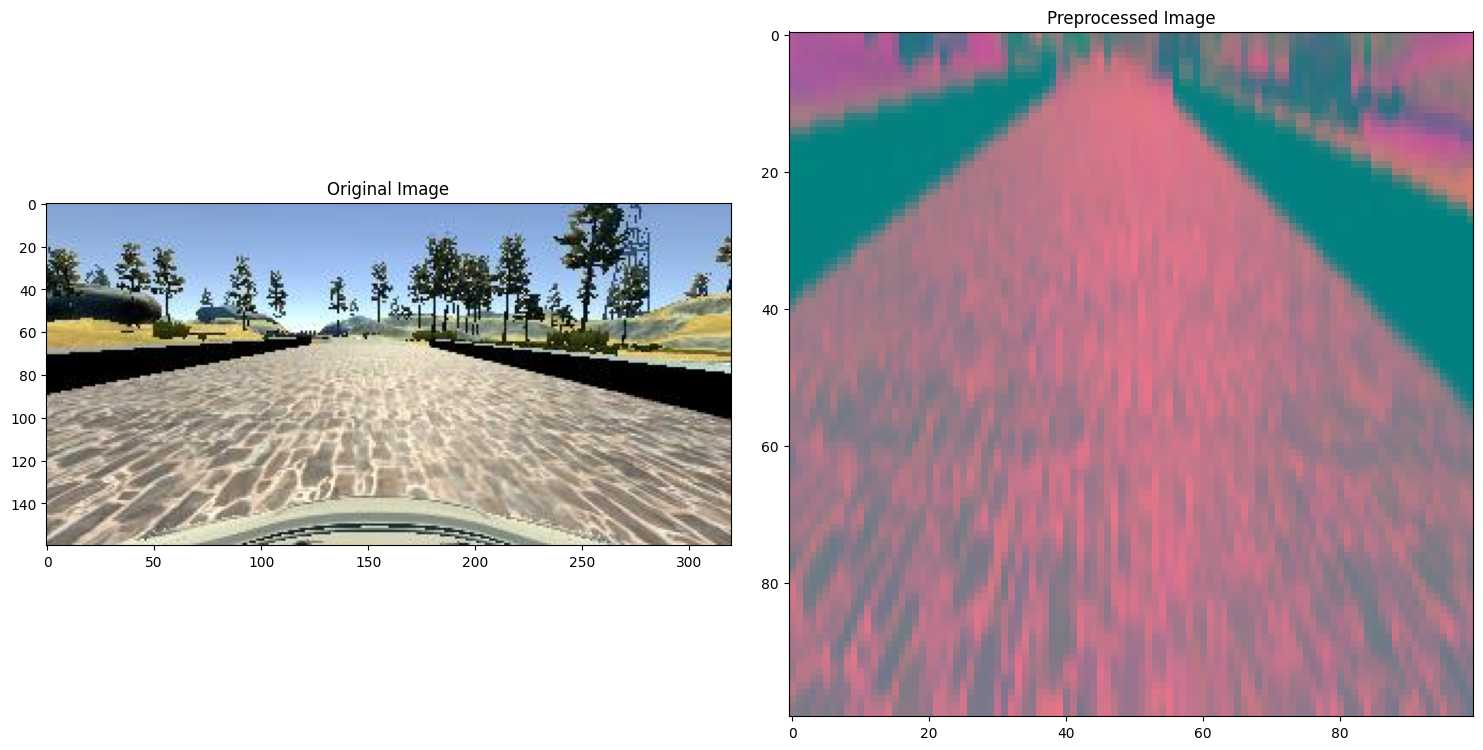

In [11]:
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [12]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

# Training Neural Network

In [13]:
from keras.applications import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

94765736/94765736 [==============================] - 17s 0us/step
<keras.engine.input_layer.InputLayer object at 0x000001C77E5E29B0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001C77EACCE50> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C77EACD2D0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001C77EACDFF0> False
<keras.layers.core.activation.Activation object at 0x000001C77EACF220> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001C77EACF5B0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C77E4ACAC0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C77E4AEB30> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001C77E4AEBC0> False
<keras.layers.core.activation.Activation object at 0x000001C77E4AFF40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C72E8390C0> False
<ker

In [14]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 100)               3276900   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

C:\Users\Urvesh Parmar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
53/53 [==============================] - 79s 1s/step - loss: 4.4690 - accuracy: 0.3872 - val_loss: 0.8457 - val_accuracy: 0.0000e+00
Epoch 2/25
53/53 [==============================] - 74s 1s/step - loss: 1.3516 - accuracy: 0.4526 - val_loss: 0.4412 - val_accuracy: 0.0000e+00
Epoch 3/25
53/53 [==============================] - 70s 1s/step - loss: 1.0451 - accuracy: 0.4829 - val_loss: 0.3112 - val_accuracy: 0.0000e+00
Epoch 4/25
53/53 [==============================] - 70s 1s/step - loss: 0.8382 - accuracy: 0.5104 - val_loss: 0.1844 - val_accuracy: 0.7677
Epoch 5/25
53/53 [==============================] - 72s 1s/step - loss: 0.6970 - accuracy: 0.5373 - val_loss: 0.1672 - val_accuracy: 0.7677
Epoch 6/25
53/53 [==============================] - 73s 1s/step - loss: 0.6139 - accuracy: 0.5467 - val_loss: 0.1570 - val_accuracy: 0.7677
Epoch 7/25
53/53 [==============================] - 73s 1s/step - loss: 0.4991 - accuracy: 0.5719 - val_loss: 0.1446 - val_accuracy: 0.7677
Epoch 8/

Text(0.5, 0, 'Epoch')

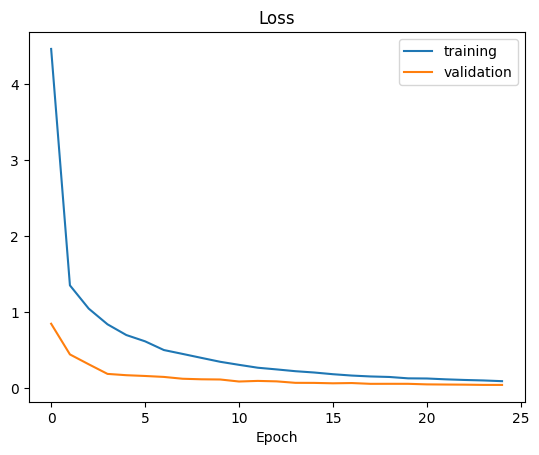

In [15]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [18]:
model.save('model_final.h5')